Populating the interactive namespace from numpy and matplotlib


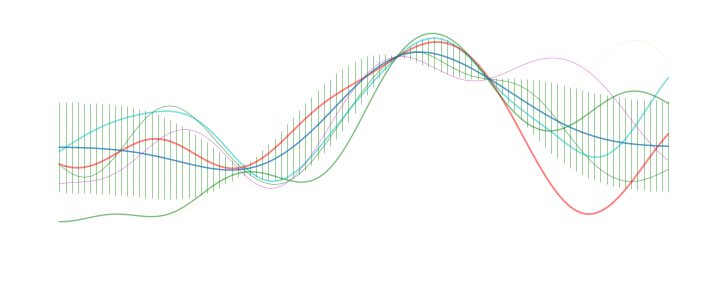

In [1]:
import numpy as np
from scipy.interpolate import spline
from scipy.linalg import cho_solve
from numpy.linalg import cholesky
from itertools import cycle

%pylab inline

class SimpleGP():
    """ One dimensional Gaussian Process class.  Uses
    squared exponential covariance form.  
    
    parameters
    ----------
    width_scale : float, positive
        Same as sigma in (4) of post

    length_scale : float, positive
        Same as l in (4) of post

    noise : float
        Added to diagonal of covariance, useful for
        improving convergence
    """
    def __init__(self, width_scale, length_scale, noise=10 ** (-6)):
        self.width_scale = width_scale
        self.length_scale = length_scale
        self.noise = noise
        
    def _exponential_cov(self, x1, x2):
        """
        Return covariance matrix for two arrays,
        with i-j element = cov(x_1i, x_2j).
        
        parameters
        ----------
        x1, x2: np.array
            arrays containing x locations
        """
        return (self.width_scale ** 2) * np.exp(
            - np.subtract.outer(x1, x2) ** 2 / (2 * self.length_scale ** 2))

    def fit(self, sample_x, sample_y, sample_s):
        """
        Save for later use the Cholesky matrix 
        associated with the inverse that appears
        in (5) of post. Also evaluate the weighted
        y vector that appears in that equation.
        
        parameters
        ----------
        sample_x : np.array
            locations where we have sampled
        
        sample_y : np.array
            y values observed at each sample location
        
        sample_s : np.array
            array of stds for each sample
        """
        
        self.sample_x = np.array(sample_x)
        
        S = self._exponential_cov(sample_x, sample_x)
        d = np.diag(np.array(sample_s) ** 2 + self.noise)
        
        self.lower_cholesky = cholesky(S + d)
        self.weighted_sample_y = cho_solve(
            (self.lower_cholesky, True), sample_y)

    def interval(self, test_x):
        """
        Obtain the one-sigam confidence interval
        for a set of test points
        
        parameters
        ----------
        test_x : np.array
            locations where we want to test
        """
        test_x = np.array([test_x]).flatten()
        means, stds = [], []
        for row in test_x:
            S0 = self._exponential_cov(row, self.sample_x)
            v = cho_solve((self.lower_cholesky, True), S0)
            means.append(np.dot(S0, self.weighted_sample_y))
            stds.append(np.sqrt(self.width_scale ** 2 - np.dot(S0, v)))
        return means, stds
    
    def sample(self, test_x, samples=1):
        """
        Obtain function samples from the posterior
        
        parameters
        ----------
        test_x : np.array
            locations where we want to test
        
        samples : int
            Number of samples to take
        """
        S0 = self._exponential_cov(test_x, self.sample_x)
        # construct covariance matrix of sampled points.
        m = []
        for row in S0:
            m.append(cho_solve((self.lower_cholesky, True), row))
        cov = self._exponential_cov(test_x, test_x) - np.dot(S0, np.array(m).T)
        mean = np.dot(S0, self.weighted_sample_y)
        return np.random.multivariate_normal(mean, cov, samples)

    
# Insert data here.  
sample_x = [0.5, 2, -2]
sample_y = [2, 1.5, -0.5]
sample_s = [0.01, 0.05, 0.125]

WIDTH_SCALE = 1
LENGTH_SCALE = 1
SAMPLES = 8
model = SimpleGP(WIDTH_SCALE, LENGTH_SCALE)
model.fit(sample_x, sample_y, sample_s)

test_x = np.arange(-5, 5, .1)
means, stds = model.interval(test_x)
samples = model.sample(test_x, SAMPLES)

# plots here.
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_ylim([-3, 3])
ax.axis('off')

colors = cycle(['g', 'b', 'k', 'y', 'c', 'r', 'm'])
plt.errorbar(test_x, means, yerr=stds,
             ecolor='g', linewidth=1.5,
             elinewidth=0.5, alpha=0.75)

for sample, c in zip(samples, colors):    
    plt.plot(test_x, sample, c, linewidth=2.*np.random.rand(), alpha=0.5)